# 3.4

In [1]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import time

In [2]:
imagedirectories=['./train/face','./train/non-face']

In [3]:
image = Image.open(os.path.join(imagedirectories[0], os.listdir(imagedirectories[0])[0]))

In [4]:
nrows, ncolumns = image.height, image.width

In [5]:
nimages=0
for i in imagedirectories:
    nimages=nimages+len(os.listdir(i))
print(nimages)

6977


In [6]:
X_tr=np.empty([nrows*ncolumns,nimages])
print(X_tr.shape)

(361, 6977)


In [7]:
file_num=0
for imagedirectory in imagedirectories:
    for filename in os.listdir(imagedirectory):
        image = Image.open(os.path.join(imagedirectory, filename))
        X_tr[:,file_num] = np.asarray(image.getdata())
        file_num=file_num+1

In [8]:
X_tr

array([[104., 112.,  91., ..., 253., 245., 175.],
       [122., 134., 109., ..., 253., 248., 159.],
       [142., 160., 132., ..., 253., 250., 167.],
       ...,
       [109., 127., 123., ..., 202.,  75.,  24.],
       [ 86.,  98.,  78., ..., 253.,  48.,  26.],
       [ 71.,  74.,  83., ..., 253.,  44.,  32.]])

In [9]:
y_1=np.ones(len(os.listdir('./train/face')))
y_2=np.ones(len(os.listdir('./train/non-face')))
y_tr=np.append(y_1,-y_2)
print(y_tr.shape)

(6977,)


In [10]:
def train_weak_learner(W,F,sample_weight,y_tr):
    minerror=1
    mine_threshold=0
    mine_sign=-1
    mine_f=0
    for f in range(F):
        thresholds=np.sort(W[f])
        arg_thresholds=np.argsort(W[f])
        errors=[]
        
        #consider first threshold and sign=1
        prediction=np.ones(W.shape[1])
        prediction[W[f]<thresholds[0]]=-1
        error=np.sum((prediction!=y_tr)*sample_weight)
        if(error<minerror):
            minerror=error
            mine_threshold=thresholds[0]
            mine_sign=1
            mine_f=f
        errors.append(error)
        
        #consider first threshold and sign=-1
        prediction=np.ones(W.shape[1])
        prediction[W[f]>=thresholds[0]]=-1
        error=np.sum((prediction!=y_tr)*sample_weight)
        if(error<minerror):
            minerror=error
            mine_threshold=thresholds[0]
            mine_sign=-1
            mine_f=f
        errors.append(error)
        
        for i in range(1,thresholds.shape[0]):
            #consider sign=1 and sign=-1
            cury=y_tr[arg_thresholds[i-1]]              
            if (cury==1):
                #when we make threshold move on, we actually change the prediction of arg_thresholds[i-1] instead of  arg_thresholds[i]
                errors[0]=errors[0]+sample_weight[arg_thresholds[i-1]]
                errors[1]=errors[1]-sample_weight[arg_thresholds[i-1]]
            else:
                errors[0]=errors[0]-sample_weight[arg_thresholds[i-1]]
                errors[1]=errors[1]+sample_weight[arg_thresholds[i-1]]
                
            if(errors[0]<minerror):
                minerror=errors[0]
                mine_threshold=thresholds[i]
                mine_sign=1
                mine_f=f     
            if(errors[1]<minerror):
                minerror=errors[1]
                mine_threshold=thresholds[i]
                mine_sign=-1
                mine_f=f     

    return minerror,mine_f,mine_sign,mine_threshold

In [11]:
# def train_weak_learner(W,F,sample_weight,y_tr):
#     minerror=1
#     mine_threshold=0
#     mine_sign=-1
#     mine_f=0
#     for f in range(F):
#         thresholds=np.sort(W[f])
#         arg_thresholds=np.argsort(W[f])
#         errors=[]
#         for sign in [-1,1]:
#             #sign=1 右face，左non-face；sign=-1，右non-face，左face
#             error=0
#             for j in range(W.shape[1]):
#                 if (W[f][j]>=thresholds[0] and sign!=y_tr[j]) or (W[f][j]<thresholds[0] and (-sign)!=y_tr[j]):
#                     error=error+sample_weight[j]
#             errors.append(error)
#             k=0
#             if (sign==1):
#                 k=1
#             if(errors[k]<minerror):
#                 minerror=errors[k]
#                 mine_threshold=thresholds[0]
#                 mine_sign=sign
#                 mine_f=f
#         for i in range(thresholds.shape[0]):
#             for sign in [-1,1]:
#                 k=0
#                 if (sign==1):
#                     k=1                
#                 cury=y_tr[arg_thresholds[i]]
#                 if (cury!=sign):
#                     errors[k]=errors[k]-sample_weight[arg_thresholds[i]]
#                 else:
#                     errors[k]=errors[k]+sample_weight[arg_thresholds[i]]
#                 if(errors[k]<minerror):
                    
#                     minerror=errors[k]
#                     #防止数组越界
#                     if (i==(thresholds.shape[0]-1)):
#                         mine_threshold=thresholds[i]+1e-16
#                     else:
#                         mine_threshold=thresholds[i]
#                     mine_sign=sign
#                     mine_f=f
#     return minerror,mine_f,mine_sign,mine_threshold

    
def get_alpha(e):
#     print(e)
    return 0.5*np.log((1-e)/e)

def adaboost_train(X_tr,y_tr,T,F):
#     minerrors=[]
    U,S,V=np.linalg.svd(X_tr)
    E=U[:,:F]
    W=np.linalg.pinv(E)@X_tr
    #initialize
    sample_weight=np.ones(X_tr.shape[1])/X_tr.shape[1]
    weak_learners=[]
    for t in range(T):
        error,f,sign,threshold=train_weak_learner(W,F,sample_weight,y_tr)
#         print(error)
#         minerrors.append(error)
        alpha_t=get_alpha(error)
        #f表示特征
        weak_learners.append([alpha_t,f,sign,threshold])
        for j in range(W.shape[1]):
            if (W[f][j]>=threshold and sign!=y_tr[j]) or (W[f][j]<threshold and (-sign)!=y_tr[j]):
                sample_weight[j]=sample_weight[j]*np.exp(alpha_t)
            else:
                sample_weight[j]=sample_weight[j]*np.exp(-alpha_t)
        sample_weight=sample_weight/np.sum(sample_weight)
#         print(sample_weight)
    return weak_learners,E

In [12]:
imagedirectories=['./test/face','./test/non-face']
image = Image.open(os.path.join(imagedirectories[0], os.listdir(imagedirectories[0])[0]))
nrows, ncolumns = image.height, image.width
nimages=0
for i in imagedirectories:
    nimages=nimages+len(os.listdir(i))
print(nimages)
X_te=np.empty([nrows*ncolumns,nimages])
print(X_te.shape)

24045
(361, 24045)


In [13]:
file_num=0
for imagedirectory in imagedirectories:
    for filename in os.listdir(imagedirectory):
        image = Image.open(os.path.join(imagedirectory, filename))
        X_te[:,file_num] = np.asarray(image.getdata())
        file_num=file_num+1

In [14]:
X_te

array([[104.,  57.,  97., ..., 233., 156., 113.],
       [102.,  59., 115., ..., 236., 159., 113.],
       [104.,  58., 145., ..., 240., 165., 117.],
       ...,
       [138., 136., 165., ..., 199., 167., 149.],
       [131., 111., 168., ..., 195., 164., 150.],
       [125.,  82., 173., ..., 190., 156., 151.]])

In [15]:
y_1=np.ones(len(os.listdir('./test/face')))
y_2=np.ones(len(os.listdir('./test/non-face')))
y_te=np.append(y_1,-y_2)
print(y_te.shape)

(24045,)


In [16]:
y_te

array([ 1.,  1.,  1., ..., -1., -1., -1.])

In [17]:
def adaboost_predict(E,X_te,model):
    W_te=np.linalg.pinv(E)@X_te
    y_pred=[]
    for i in range(W_te.shape[1]):
        tempsum=0
        for weak_learner in model:
            alpha=weak_learner[0]
            f=weak_learner[1]
            sign=weak_learner[2]
            threshold=weak_learner[3]
            if W_te[f][i]>=threshold:
                if sign==1:
                    tempsum=tempsum+alpha
                else:
                    tempsum=tempsum-alpha
            else:
                if sign==1:
                    tempsum=tempsum-alpha
                else:
                    tempsum=tempsum+alpha
        y_pred.append(np.sign(tempsum))
    return y_pred

# 3.5.2

In [18]:
train_error=[]
test_error=[]
Ts=[10,50,100,150,200]
time_start=time.time()
model,eigenfaces=adaboost_train(X_tr,y_tr,200,10)
time_end=time.time()
print('time cost',time_end-time_start,'s')
for T in Ts:
    y_pred_tr=adaboost_predict(eigenfaces,X_tr,model[:T])
    tr_e=1-np.sum(y_pred_tr==y_tr)/y_tr.shape[0]
    y_pred_te=adaboost_predict(eigenfaces,X_te,model[:T])
    te_e=1-np.sum(y_pred_te==y_te)/y_te.shape[0]
    train_error.append(tr_e)
    test_error.append(te_e)

time cost 9.490286350250244 s


In [19]:
model

[[0.5951793663354022, 3, 1, 39.118717758157345],
 [0.4574632131874288, 1, 1, 114.37401860251907],
 [0.3661597790633906, 2, -1, -57.724531065082765],
 [0.2917263860786582, 7, -1, -2.30532502309002],
 [0.2999736440449589, 5, -1, -73.00925869507387],
 [0.31943436656262014, 3, 1, -52.524815067657414],
 [0.3654483689759868, 0, -1, -2662.4660881824257],
 [0.3911821221845733, 1, 1, -103.52446734216005],
 [0.2586717346930103, 6, 1, 4.8066192364019],
 [0.20549332332268538, 9, 1, 15.925083746796872],
 [0.2036671633363459, 1, 1, 478.1760448348847],
 [0.26248581385578706, 3, 1, -136.84057709649483],
 [0.22876616295734578, 0, -1, -2360.16599131149],
 [0.18005732170399602, 2, -1, -131.75535658886122],
 [0.2038779924465911, 1, 1, -250.47038490460733],
 [0.20773744693952814, 0, -1, -3584.849771571209],
 [0.20176700477739898, 0, -1, -1464.8001686484486],
 [0.15876287372995945, 8, -1, -18.501836254566214],
 [0.14025584318859563, 3, 1, -190.0743206128206],
 [0.21634966252895957, 1, 1, 702.2906319179976],

In [20]:
train_error

[0.12397878744446034,
 0.07123405475132583,
 0.0632076823849792,
 0.05933782427977641,
 0.05790454350007168]

In [21]:
test_error

[0.16697858182574343,
 0.09881472239550837,
 0.08725306716573089,
 0.08039093366604289,
 0.0800998128509045]

[]

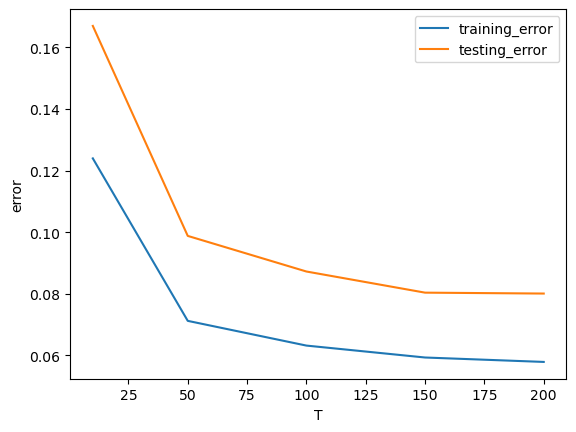

In [22]:
fig,ax=plt.subplots()
ax.plot(Ts,train_error,label="training_error")
ax.plot(Ts,test_error,label="testing_error")
ax.set_xlabel("T")
ax.set_ylabel("error")
ax.legend()
plt.plot()

# 3.5.3

[]

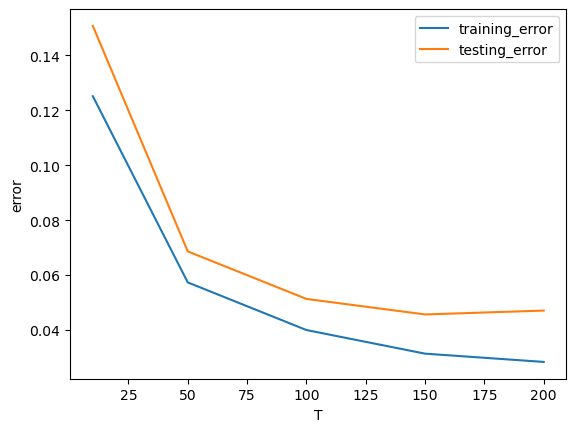

In [23]:
#k=F=30
train_error=[]
test_error=[]
Ts=[10,50,100,150,200]
model,eigenfaces=adaboost_train(X_tr,y_tr,200,30)
for T in Ts:
    y_pred_tr=adaboost_predict(eigenfaces,X_tr,model[:T])
    tr_e=1-np.sum(y_pred_tr==y_tr)/y_tr.shape[0]
    y_pred_te=adaboost_predict(eigenfaces,X_te,model[:T])
    te_e=1-np.sum(y_pred_te==y_te)/y_te.shape[0]
    train_error.append(tr_e)
    test_error.append(te_e)
fig,ax=plt.subplots()
ax.plot(Ts,train_error,label="training_error")
ax.plot(Ts,test_error,label="testing_error")
ax.set_xlabel("T")
ax.set_ylabel("error")
ax.legend()
plt.plot()

In [24]:
model

[[0.5951793663354022, 3, 1, 39.11871775815746],
 [0.4574632131874288, 1, 1, 114.37401860251862],
 [0.3661597790633906, 2, -1, -57.7245310650833],
 [0.2917263860786582, 7, -1, -2.305325023089911],
 [0.2999736440449589, 5, -1, -73.00925869507404],
 [0.31943436656262014, 3, 1, -52.5248150676573],
 [0.3654483689759868, 0, -1, -2662.4660881824257],
 [0.3911821221845733, 1, 1, -103.52446734216028],
 [0.2586717346930103, 6, 1, 4.8066192364011044],
 [0.24229759597625822, 21, -1, -38.465901628909705],
 [0.20943901844800888, 0, -1, -1619.2252769819731],
 [0.22155564416548845, 11, 1, 14.106133199037131],
 [0.20380599907557304, 9, 1, 15.9250837467971],
 [0.19992127135764517, 19, -1, -48.33636015464674],
 [0.24968992842633103, 3, 1, -136.8405770964955],
 [0.24665202208511863, 1, 1, 478.17604483488435],
 [0.2287278456814322, 27, 1, -31.26343670308118],
 [0.19630855094605137, 8, -1, -18.420743725682996],
 [0.20259423338190005, 18, 1, -6.095766444269341],
 [0.19007342710238395, 2, -1, 1.50077615320043

[]

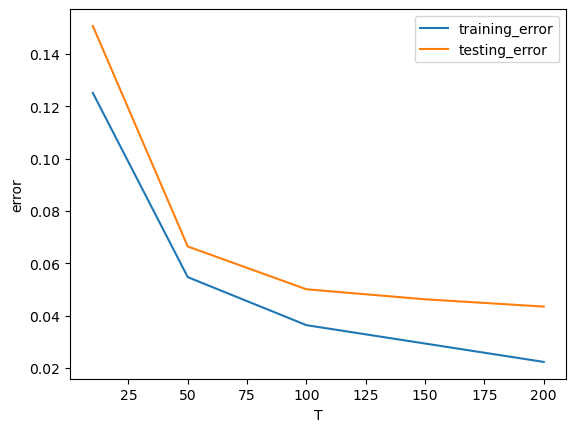

In [25]:
#k=F=50
train_error=[]
test_error=[]
Ts=[10,50,100,150,200]
model,eigenfaces=adaboost_train(X_tr,y_tr,200,50)
for T in Ts:
    y_pred_tr=adaboost_predict(eigenfaces,X_tr,model[:T])
    tr_e=1-np.sum(y_pred_tr==y_tr)/y_tr.shape[0]
    y_pred_te=adaboost_predict(eigenfaces,X_te,model[:T])
    te_e=1-np.sum(y_pred_te==y_te)/y_te.shape[0]
    train_error.append(tr_e)
    test_error.append(te_e)
fig,ax=plt.subplots()
ax.plot(Ts,train_error,label="training_error")
ax.plot(Ts,test_error,label="testing_error")
ax.set_xlabel("T")
ax.set_ylabel("error")
ax.legend()
plt.plot()

# 3.5.4

In [26]:
def center(M):
    mu=np.mean(M,axis=1,keepdims=True) #(4096,1)
    M=M-mu # (4096,1071)
    return M

In [27]:
def ICA(M):
    R_MM=M@np.transpose(M) #(4096,4096)
    E,diag,temp=np.linalg.svd(R_MM) # (4096,4096)
    C=np.diag(diag**(-0.5))@np.transpose(E) #(4096,4096)@(4096,4096)= (4096,4096)
    X=C@M #(4096,4096)@(4096,1071)=(4096,1071)  
#     print('mean of each row:',np.mean(X,axis=1))
#     print('variance of each row:',np.var(X,axis=1))
    X_col_norm=np.sum(X**2,axis=0) #(1071,1)
    D=(X@(X*X_col_norm).T)/X.shape[1] #(4096,4096)
    U,eigenvalue,temp=np.linalg.svd(D)
    A=np.transpose(U)@C
    ICA_faces=np.linalg.pinv(A)
#     H=A@M
#     #return H+mean
#     ICA_faces=H+mu
    return ICA_faces

In [28]:
def getICA(M):
    ICA_faces=ICA(M)
    return ICA_faces

In [29]:
def adaboost_train(X_tr,y_tr,T,F,ICA_faces):
#     minerrors=[]
    W=np.linalg.pinv(ICA_faces)@X_tr
    #initialize
    sample_weight=np.ones(X_tr.shape[1])/X_tr.shape[1]
    weak_learners=[]
    for t in range(T):
        error,f,sign,threshold=train_weak_learner(W,F,sample_weight,y_tr)
#         minerrors.append(error)
        alpha_t=get_alpha(error)
        #f表示特征
        weak_learners.append([alpha_t,f,sign,threshold])
        for j in range(W.shape[1]):
            if (W[f][j]>=threshold and sign!=y_tr[j]) or (W[f][j]<threshold and (-sign)!=y_tr[j]):
                sample_weight[j]=sample_weight[j]*np.exp(alpha_t)
            else:
                sample_weight[j]=sample_weight[j]*np.exp(-alpha_t)
        sample_weight=sample_weight/np.sum(sample_weight)
    return weak_learners

In [30]:
def adaboost_predict(ICA_faces,X_te,model):
    W_te=np.linalg.pinv(ICA_faces)@X_te
    y_pred=[]
    for i in range(W_te.shape[1]):
        tempsum=0
        for weak_learner in model:
            alpha=weak_learner[0]
            f=weak_learner[1]
            sign=weak_learner[2]
            threshold=weak_learner[3]
            if W_te[f][i]>=threshold:
                if sign==1:
                    tempsum=tempsum+alpha
                else:
                    tempsum=tempsum-alpha
            else:
                if sign==1:
                    tempsum=tempsum-alpha
                else:
                    tempsum=tempsum+alpha
        y_pred.append(np.sign(tempsum))
    return y_pred

In [31]:
model

[[0.5951793663354022, 3, 1, 39.11871775815683],
 [0.4574632131874288, 1, 1, 114.37401860251862],
 [0.3661597790633906, 2, -1, -57.72453106508308],
 [0.2917263860786582, 7, -1, -2.3053250230899685],
 [0.2999736440449589, 5, -1, -73.00925869507398],
 [0.31943436656262014, 3, 1, -52.52481506765639],
 [0.3654483689759868, 0, -1, -2662.4660881824257],
 [0.3911821221845733, 1, 1, -103.52446734216073],
 [0.2586717346930103, 6, 1, 4.80661923640065],
 [0.24229759597625822, 21, -1, -38.465901628909734],
 [0.20943901844800888, 0, -1, -1619.2252769819734],
 [0.22155564416548845, 11, 1, 14.106133199037117],
 [0.20380599907557304, 9, 1, 15.925083746796957],
 [0.19992127135764517, 19, -1, -48.33636015464635],
 [0.24968992842633103, 3, 1, -136.84057709649585],
 [0.24665202208511863, 1, 1, 478.1760448348846],
 [0.2287278456814322, 27, 1, -31.2634367030812],
 [0.19630855094605137, 8, -1, -18.420743725683067],
 [0.20259423338190005, 18, 1, -6.095766444269568],
 [0.19007342710238395, 2, -1, 1.500776153200

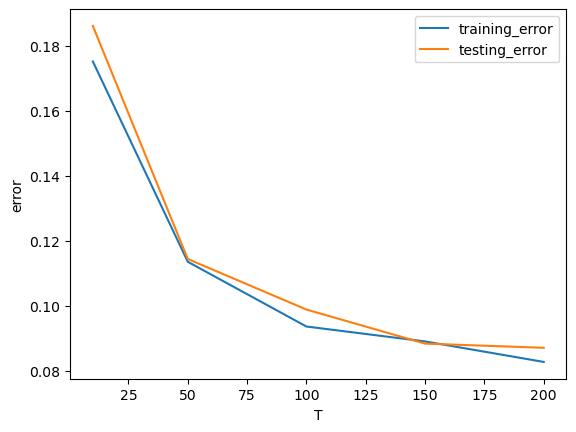

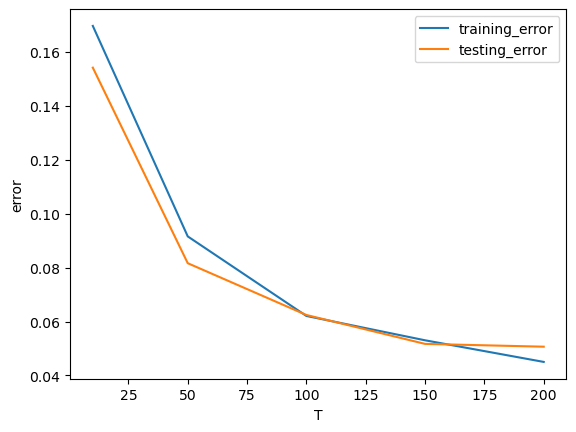

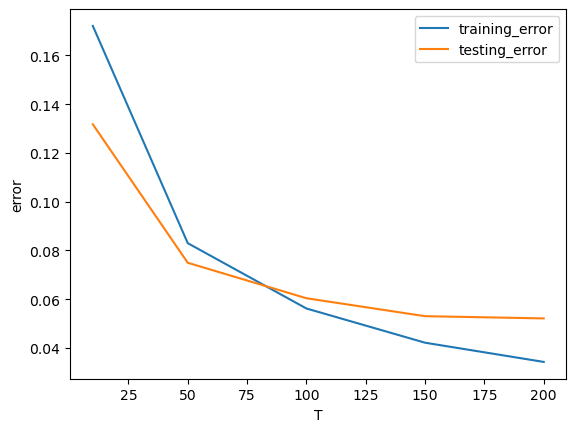

In [32]:
X_tr_centered=center(X_tr)
ICA_faces=getICA(X_tr_centered)
for k in [10,30,50]:
    train_error=[]
    test_error=[]
    model=adaboost_train(X_tr,y_tr,200,k,ICA_faces[:,:k])
    Ts=[10,50,100,150,200]
    for T in Ts:
        y_pred_tr=adaboost_predict(ICA_faces[:,:k],X_tr,model[:T])
        tr_e=1-np.sum(y_pred_tr==y_tr)/y_tr.shape[0]
        y_pred_te=adaboost_predict(ICA_faces[:,:k],X_te,model[:T])
        te_e=1-np.sum(y_pred_te==y_te)/y_te.shape[0]
        train_error.append(tr_e)
        test_error.append(te_e)
    fig,ax=plt.subplots()
    ax.plot(Ts,train_error,label="training_error")
    ax.plot(Ts,test_error,label="testing_error")
    ax.set_xlabel("T")
    ax.set_ylabel("error")
    ax.legend()
    plt.plot()